<a href="https://colab.research.google.com/github/SergSof/beeVSwasp/blob/main/%D0%A2%D0%97_%22beeVSwasp%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

In [2]:
print(tf.__version__)

2.4.1


In [3]:
from google.colab import drive  # подключаем диск
drive.mount('/content/drive')  #необходимо ввести свой ключ активации

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/beeVSwasp.zip .  #копируем архив с гугл-диска на вирт. машину
!mkdir beeVSwasp   # создаем папку "beeVSwasp"
!unzip beeVSwasp.zip -d beeVSwasp  #распаковываем  в папку "beeVSwasp"

In [5]:
min_size_w = 400
min_size_h = 400 # начальные значения
n_del = 0

for path in ('beeVSwasp/wasp/', 'beeVSwasp/bee/'):
  for img in os.listdir(path):
    
    im = PIL.Image.open(path+img) 
    if im.format != 'JPEG' or im.mode != 'RGB':
      n_del +=1
      #display(im)
      os.remove(path+img) # удаление файлов не соответствующих по формату или по цвет. представлению
      continue
   
    width, height = im.size
    if min_size_w > width:
      min_size_w = width
    if min_size_h > height:
      min_size_h = height

print('Минимальная высота - ', min_size_h)
print('Минимальная ширина - ', min_size_w)
print('Всего удалено файлов - ', n_del)

print('Количество картинок с пчелами - ', len(os.listdir('beeVSwasp/bee/'))) 
print('Количество картинок с осами - ', len(os.listdir('beeVSwasp/wasp/')))
image_count = len(os.listdir('beeVSwasp/wasp/')) + len(os.listdir('beeVSwasp/bee/'))
print('Всего изображений - ', image_count)

Минимальная высота -  124
Минимальная ширина -  124
Всего удалено файлов -  5
Количество картинок с пчелами -  2466
Количество картинок с осами -  2125
Всего изображений -  4591


In [6]:

data_dir = '/content/beeVSwasp/'
padding = "SAME"  #@param ['SAME', 'VALID' ]
output_classes = 2  #@param {type: "number"}
batch_size = 32  #@param {type: "number"}
learning_rate = 0.0001  #@param {type: "number"}
img_height = 300  #@param {type: "number"}
img_width = 300  #@param {type: "number"}

In [7]:
list_ds = tf.data.Dataset.list_files(str(data_dir)+'*/*', shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)


In [8]:
for f in list_ds.take(5):
  print(f.numpy())

b'/content/beeVSwasp/bee/5941413889_b3f2ff8236_m.jpg'
b'/content/beeVSwasp/bee/21546842900_fdf084dab3_n.jpg'
b'/content/beeVSwasp/bee/7570481736_9d00594f4e_w.jpg'
b'/content/beeVSwasp/bee/25897310773_ea65248584_n.jpg'
b'/content/beeVSwasp/wasp/489290488_4ad5090d0e_n.jpg'


In [9]:
class_names = np.array(os.listdir(data_dir))#np.array( sorted([item for item in os.listdir(data_dir)]))
print(os.listdir(data_dir))
print(class_names)

['wasp', 'bee']
['wasp' 'bee']


In [10]:
val_size = int(image_count * 0.2)
print(len(list_ds))
train_ds = list_ds.skip(val_size)
print(len(train_ds))
val_ds = list_ds.take(val_size)
print(len(val_ds))
 


4591
3673
918


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)



In [12]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

3673
918


In [13]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  #print(list(file_path.numpy()))
  one_hot = parts[-2] == class_names
  #print(tf.argmax(one_hot))
  return tf.argmax(one_hot)

In [14]:
def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=3)
  return tf.image.resize(img, [img_height, img_width])

In [15]:
def process_path(file_path):
  label = get_label(file_path)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [16]:

train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
print(AUTOTUNE)

-1


In [17]:
for image, label in train_ds.take(2):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (300, 300, 3)
Label:  1
Image shape:  (300, 300, 3)
Label:  1


In [18]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)


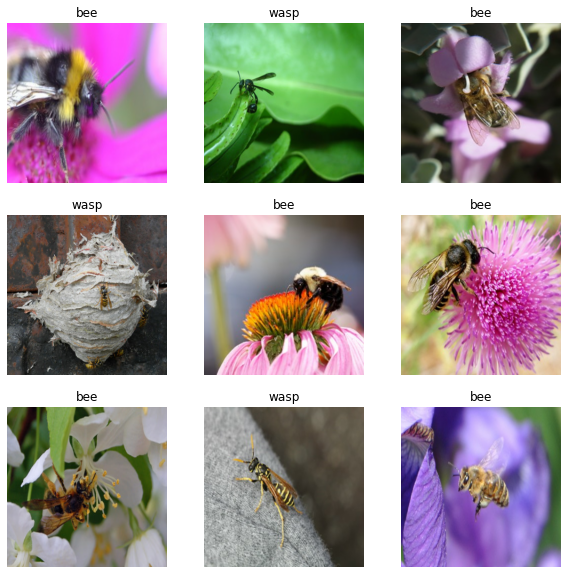

In [19]:
import matplotlib.pyplot as plt
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [20]:

leaky_relu_alpha = 0.1 #@param {type: "number"}
dropout_rate = 0.25 #@param {type: "number"}


def conv2d( inputs , filters , stride_size ):
    out = tf.nn.conv2d( inputs , filters , strides=[ 1 , stride_size , stride_size , 1 ] , padding=padding ) 
    return tf.nn.leaky_relu( out , alpha=leaky_relu_alpha ) 

def maxpool( inputs , pool_size , stride_size ):
    return tf.nn.max_pool2d( inputs , ksize=[ 1 , pool_size , pool_size , 1 ] , padding='VALID' , strides=[ 1 , stride_size , stride_size , 1 ] )

def dense( inputs , weights ):
    x = tf.nn.leaky_relu( tf.matmul( inputs , weights ) , alpha=leaky_relu_alpha )
    return tf.nn.dropout( x , rate=dropout_rate )


In [21]:

initializer = tf.initializers.glorot_uniform()
def get_weight( shape , name ):
    return tf.Variable( initializer( shape ) , name=name , trainable=True , dtype=tf.float32 )

shapes = [
    [ 3 , 3 , 3 , 16 ] , 
    [ 3 , 3 , 16 , 16 ] , 
    [ 3 , 3 , 16 , 32 ] , 
    [ 3 , 3 , 32 , 32 ] ,
    [ 3 , 3 , 32 , 64 ] , 
    [ 3 , 3 , 64 , 64 ] ,
    [ 3 , 3 , 64 , 128 ] , 
    [ 3 , 3 , 128 , 128 ] ,
    [ 3 , 3 , 128 , 256 ] , 
    [ 3 , 3 , 256 , 256 ] ,
    [ 3 , 3 , 256 , 512 ] , 
    [ 3 , 3 , 512 , 512 ] ,
    [ 8192 , 3600 ] , 
    [ 3600 , 2400 ] ,
    [ 2400 , 1600 ] , 
    [ 1600 , 800 ] ,
    [ 800 , 64 ] ,
    [ 64 , output_classes ] ,
]

weights = []
for i in range( len( shapes ) ):
    weights.append( get_weight( shapes[ i ] , 'weight{}'.format( i ) ) )


In [22]:

def model( x ) :
    x = tf.cast( x , dtype=tf.float32 )
    c1 = conv2d( x , weights[ 0 ] , stride_size=1 ) 
    c1 = conv2d( c1 , weights[ 1 ] , stride_size=1 ) 
    p1 = maxpool( c1 , pool_size=2 , stride_size=2 )
    
    c2 = conv2d( p1 , weights[ 2 ] , stride_size=1 )
    c2 = conv2d( c2 , weights[ 3 ] , stride_size=1 ) 
    p2 = maxpool( c2 , pool_size=2 , stride_size=2 )
    
    c3 = conv2d( p2 , weights[ 4 ] , stride_size=1 ) 
    c3 = conv2d( c3 , weights[ 5 ] , stride_size=1 ) 
    p3 = maxpool( c3 , pool_size=2 , stride_size=2 )
    
    c4 = conv2d( p3 , weights[ 6 ] , stride_size=1 )
    c4 = conv2d( c4 , weights[ 7 ] , stride_size=1 )
    p4 = maxpool( c4 , pool_size=2 , stride_size=2 )

    c5 = conv2d( p4 , weights[ 8 ] , stride_size=1 )
    c5 = conv2d( c5 , weights[ 9 ] , stride_size=1 )
    p5 = maxpool( c5 , pool_size=2 , stride_size=2 )

    c6 = conv2d( p5 , weights[ 10 ] , stride_size=1 )
    c6 = conv2d( c6 , weights[ 11 ] , stride_size=1 )
    p6 = maxpool( c6 , pool_size=2 , stride_size=2 )

    flatten = tf.reshape( p6 , shape=( tf.shape( p6 )[0] , -1 ))

    d1 = dense( flatten , weights[ 12 ] )
    d2 = dense( d1 , weights[ 13 ] )
    d3 = dense( d2 , weights[ 14 ] )
    d4 = dense( d3 , weights[ 15 ] )
    d5 = dense( d4 , weights[ 16 ] )
    logits = tf.matmul( d5 , weights[ 17 ] )
  
    return tf.nn.sigmoid( logits )#sigmoid softmax


In [23]:

def loss( pred , target ):
    return tf.losses.categorical_crossentropy( target , pred )

optimizer = tf.optimizers.Adam( learning_rate )

def train_step( model, inputs , outputs ):
    with tf.GradientTape() as grad:
        current_loss = loss( model( inputs ), outputs)
    grads = grad.gradient( current_loss, weights )
    optimizer.apply_gradients( zip( grads , weights ) )
    print( tf.reduce_mean( current_loss ) )  

In [ ]:

num_epochs = 10

for e in range( num_epochs ):
    print('Эпоха №', e+1)
   
    for features in train_ds:
        image , label = features[0] , features[1]
        image = image / 255.0
        train_step( model , image , tf.one_hot( label , depth=2 ) )
          